In [8]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import xml.etree.ElementTree as ET
import csv
%matplotlib inline
num_cpu = 64 #The number of CPU cores on the machine the data was collected from
outputfolder = "22_aug/ARM_8cores" #Folder which contains collected data_files
outputfolder = "output_arm"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
perfFile = outputfolder+"/perf.txt"
envFile = outputfolder+"/env.txt"



# getClientServerCPUs(envFile)
    
def writeCSV(filename,sorted_op,benchStdMean):
    ''' Writes the data to a CSV file'''
    x = []
    x.append("Operations")
    for value in sorted(benchStdMean, key=str.lower):
        x.append(value)

    y = []
    y.append(x)
    for i in range(len(sorted_op)):
        x=[]
        x.append(sorted_op[i])
        for value in sorted(benchStdMean, key=str.lower):
            x.append(benchStdMean[value][i])
        y.append(x)
    with open(filename,"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(y)
''' The following are the parsing modules for the different files generated '''

def getClientServerCPUs(envFile):
    clientCPU = None
    serverCPU = None
    with open(envFile) as f:
        lines = f.readlines()
        for line in lines:
            if re.search('CLIENT_CPUS', line, re.I):
                CPUs = line.replace('\n','').split('=')[1]
                if CPUs.isdigit():
                    clientCPU = [int(CPUs)]
                else:
                    CPUs = CPUs.split("-")
                    if not (CPUs[0].isdigit() and CPUs[1].isdigit()):
                        print("ERRORERRORERROR")
                    else:
                        clientCPU = range(int(CPUs[0]),int(CPUs[1]) + 1)
            if re.search('SERVER_CPUS', line, re.I):
                CPUs = line.replace('\n','').split('=')[1]
                if CPUs.isdigit():
                    serverCPU = [int(CPUs)]
                else:
                    CPUs = CPUs.split("-")
                    if not (CPUs[0].isdigit() and CPUs[1].isdigit()):
                        print("ERRORERRORERROR")
                    else:
                        serverCPU = range(int(CPUs[0]),int(CPUs[1]) + 1)
    return serverCPU,clientCPU


def readCPUUtil(utilFile,serverCPU,clientCPU):
    idle_times={}
    for i in range(num_cpu):
        idle_times[i]=[]
    with open(utilFile) as f:
        utilBigList = f.read().split("@")[1:]
    for utilSingle in utilBigList:
        idle_times_temp = {}
        for i in range(num_cpu):
            idle_times_temp[i]=[]
        stringNewLine = utilSingle.split('\n')[2:]
        for stringLine in stringNewLine:        
            words = stringLine.split()
            if(len(words)>=2 and words[-11].isdigit()):
                CPU = int(words[-11])
                idle = float(words[-1].rstrip('\x00'))
                idle_times_temp[CPU].append(idle)
        for i in range(num_cpu):
            idle_times[i].append(idle_times_temp[i])
    idle_times_avg = {}
    for i in range(num_cpu):
        idle_times_avg[i]=[]
        for times in idle_times[i]:
            idle_times_avg[i].append(np.mean(times))
    for cpu in idle_times_avg:
        idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
    util_bench = idle_times_avg[0]*0
    util_server = idle_times_avg[0]*0
    for i in range(num_cpu):
        if i in clientCPU:
            util_bench = util_bench + idle_times_avg[i]
        elif i in serverCPU:
            util_server = util_server + idle_times_avg[i]
    util_bench = 100.0 - util_bench/len(clientCPU)
    util_server = 100.0 - util_server/(len(serverCPU))
    return {
        "CPUUtilClient":util_bench,
        "CPUUtilServer":util_server
    }

def readOperations(operationsFile):
    with open(operationsFile) as f:                                                                                                                                                                                     
        operationsStr = f.read().split('\n')[:-1]
    operations = np.array(map(int, operationsStr))
    return operations
def show(elem):
    print elem.tag
    for child in elem.findall('*'):
        show(child)
        
        
def readPerf(perfFile):
    instructionsU = []
    instructionsK = []
    cycles = []
    with open(perfFile) as f:
        lines = f.readlines()
        for line in lines:
            if re.search('instructions:u', line, re.I):
                instructionsU.append(float(line.split()[0].replace(',','')))
            if re.search('instructions:k', line, re.I):
                instructionsK.append(float(line.split()[0].replace(',','')))
            if re.search('cycles', line, re.I):
                cycles.append(float(line.split()[0].replace(',','')))
    instructionsU = np.array(instructionsU)
    instructionsK = np.array(instructionsK)
    cycles = np.array(cycles)
    ipcU = instructionsU/cycles
    ipcK = instructionsK/cycles
    ipcTotal = ipcU + ipcK
    return {
        "instructionsU":instructionsU,
        "instructionsK":instructionsK,
        "cycles":cycles,
        "ipcU":ipcU,
        "ipcK":ipcK,
        "ipcTotal":ipcTotal
    }

                
                
def readBenchmark(benchmarkFile):
    xmlList = []
    start = 0
    with open(benchmarkFile) as f:
        content = f.read()
        while(True):
            a = ( string.find(content,"<benchResults>"))
            
            b = ( string.find(content[start:],"</benchResults>")) + len("</benchResults>")

            if (a is not -1 and b is not -1):
                xmlList.append(content[a:b])
                content = content[b:]
            else:
                break
    avg = []
    p90th = []
    p99th = []
    totalOps = []
    throughput = []
    for xml in xmlList:
        benchResult = ET.fromstring(xml)
        driverSummary = benchResult.find("driverSummary")
        avg.append(float(driverSummary.find("responseTimes/operation/avg").text))
        p90th.append(float(driverSummary.find("responseTimes/operation/p90th").text.replace('>','')))
        p99th.append(float(driverSummary.find("responseTimes/operation/p99th").text.replace('>','')))
        totalOps.append(float(driverSummary.find("totalOps").text))
        throughput.append(float(driverSummary.find("metric").text))
    return {
        "avg":avg,
        "p90th":p90th,
        "p99th":p99th,
        "totalOps":totalOps,
        "throughput":throughput
    }

In [9]:
''' This blocks calculates the mean an standard deviation using the different values corresponding to the same load (operation)'''
operations = readOperations(operationsFile)
bench1 = readBenchmark(benchmarkFile)
perf1 = readPerf(perfFile)
serverCPU,clientCPU = getClientServerCPUs(envFile)
util1 = readCPUUtil(utilFile,serverCPU=serverCPU,clientCPU=clientCPU)

for x in perf1:
    bench1[x] = perf1[x]
for x in util1:
    bench1[x] = util1[x]

values = ["avg","p90th","p99th","totalOps","throughput","CPUUtilClient","CPUUtilServer","instructionsU","instructionsK","cycles","ipcU","ipcK","ipcTotal"]
benchStdMean = {}
for value in values:
    benchStdMean[value] = []
operations = operations[0:len(bench1["avg"])]

unique_op={}
for i in range(len(operations)):
    if operations[i] not in unique_op:
        unique_op[operations[i]] = operations[i]
sorted_op = np.sort(unique_op.keys())
for op in sorted_op:
    ii = np.where(operations == op)[0]
    for value in values:
        benchStdMean[value].append(np.take(bench1[value],ii))
for value in values:
    benchStdMean[value+"Mean"] = []
    for x in benchStdMean[value]:
        if len(x) is 0:
            print(value)
            print(x)
        benchStdMean[value+"Mean"].append(np.mean(x)) 
    benchStdMean[value+"Std"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Std"].append(np.std(x)) 
for value in benchStdMean:
    benchStdMean[value]=np.array(benchStdMean[value])


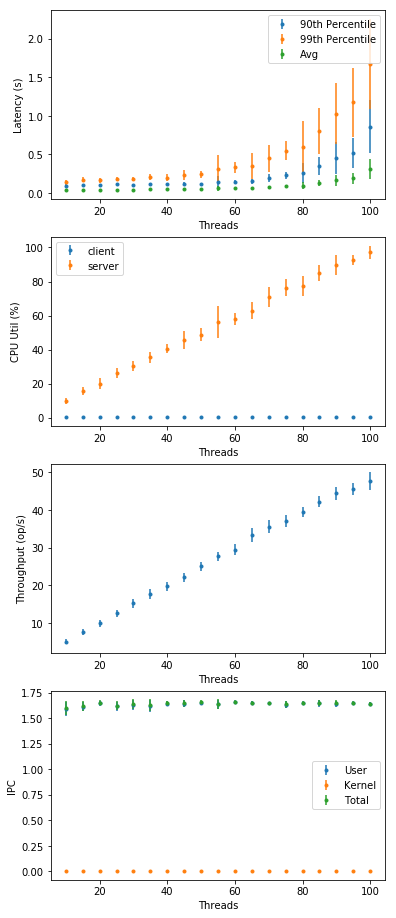

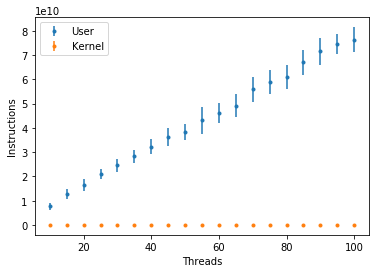

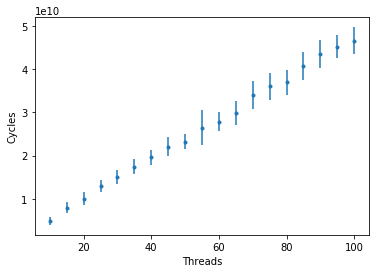

In [10]:

fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.errorbar(sorted_op,benchStdMean["p90thMean"],yerr = benchStdMean["p90thStd"],label="90th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["p99thMean"],yerr = benchStdMean["p99thStd"],label="99th Percentile",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["avgMean"],yerr = benchStdMean["avgStd"],label="Avg",linestyle='None',marker=".")

plt.xlabel("Threads")
plt.ylabel("Latency (s)")
plt.legend()

plt.subplot(4,1,2)
plt.errorbar(sorted_op,benchStdMean["CPUUtilClientMean"],yerr = benchStdMean["CPUUtilClientStd"],label="client",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["CPUUtilServerMean"],yerr = benchStdMean["CPUUtilServerStd"],label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("CPU Util (%)")


plt.subplot(4,1,3)
plt.errorbar(sorted_op,benchStdMean["throughputMean"],yerr = benchStdMean["throughputStd"],label="Throughput",linestyle='None',marker=".")
plt.xlabel("Threads")
plt.ylabel("Throughput (op/s)")

plt.subplot(4,1,4)
plt.errorbar(sorted_op,benchStdMean["ipcUMean"],yerr = benchStdMean["ipcUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcKMean"],yerr = benchStdMean["ipcKStd"],label="Kernel",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("IPC")

plt.savefig(outputfolder + "/plot.png",bbox_inches='tight')
# plt.savefig("Web_search_result.png")
plt.show()
plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["instructionsUMean"],yerr = benchStdMean["instructionsUStd"],label="User",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["instructionsKMean"],yerr = benchStdMean["instructionsKStd"],label="Kernel",linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Threads")
plt.ylabel("Instructions")
plt.show()
plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["cyclesMean"],yerr = benchStdMean["cyclesStd"],linestyle='None',marker=".")
# plt.errorbar(sorted_op,benchStdMean["ipcTotalMean"],yerr = benchStdMean["ipcTotalStd"],label="Total",linestyle='None',marker=".")
# plt.legend()
plt.xlabel("Threads")
plt.ylabel("Cycles")
plt.show()

writeCSV(outputfolder+"/summary.csv",sorted_op,benchStdMean)

In [11]:
print(sorted_op)
for op in sorted_op:
    print("{}:{}".format(op,np.count_nonzero(operations == op)))

[ 10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
 100]
10:16
15:16
20:16
25:16
30:16
35:16
40:16
45:16
50:16
55:16
60:16
65:16
70:16
75:16
80:16
85:16
90:16
95:16
100:16


In [12]:
serverCPU

[16, 17]